In [4]:
import numpy as np
import pandas as pd
from time import time
from sklearn import metrics
from collections import defaultdict
import matplotlib.pyplot as plt
import glob
import seaborn as sns


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from sklearn.metrics.cluster import contingency_matrix

## profiling
from pandas_profiling import ProfileReport
%matplotlib inline

## Gas Turbine CO and NOx Emission Data Set

In [5]:
path = 'pp_gas_emission/'
all_files = glob.glob(path + "/*.csv")
li = []
years = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['year'] = int(filename[-8:-4])
    years.append(int(int(filename[-8:-4])))
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

## predict the criteria pollutants in a particular region - CO

## Standardize feature columns 

In [6]:
frame.drop('NOX',axis =1,inplace=True)

In [7]:
years

[2013, 2015, 2014, 2012, 2011]

One hot encode the year column (doesn't work for profiler)

In [116]:
one_hot = pd.get_dummies(frame['year'])
frame_catdata = frame.drop('year',axis=1)
frame_catdata = frame.join(one_hot)
# # frame["year_cat"] = frame["year"].astype("category") 

In [118]:
frame_catdata

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0      9.3779  1020.1  90.262  2.3927  19.166  1043.6  541.16  110.16  10.564   
1      9.2985  1019.9  89.934  2.3732  19.119  1039.9  538.94  109.23  10.572   
2      9.1337  1019.8  89.868  2.3854  19.178  1041.0  539.47  109.62  10.543   
3      8.9715  1019.3  89.490  2.3825  19.180  1037.1  536.89  108.88  10.458   
4      9.0157  1019.1  89.099  2.4044  19.206  1043.5  541.25  110.09  10.464   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
36728  9.0301  1005.6  98.460  3.5421  19.164  1049.7  546.21  111.61  10.400   
36729  7.8879  1005.9  99.093  3.5059  19.414  1046.3  543.22  111.78  10.433   
36730  7.2647  1006.3  99.496  3.4770  19.530  1037.7  537.32  110.19  10.483   
36731  7.0060  1006.8  99.008  3.4486  19.377  1043.2  541.24  110.74  10.533   
36732  6.9279  1007.2  97.533  3.4275  19.306  1049.9  545.85  111.58  10.583   

            CO  year year_cat  2011  2012  2013  2014  2015  
0       9.3472  2013     2013     0     0     1     0     0  
1      11.0160  2013     2013     0     0     1     0     0  
2      10.7500  2013     2013     0     0     1     0     0  
3      12.2870  2013     2013     0     0     1     0     0  
4       9.8229  2013     2013     0     0     1     0     0  
...        ...   ...      ...   ...   ...   ...   ...   ...  
36728   4.5186  2011     2011     1     0     0     0     0  
36729   4.8470  2011     2011     1     0     0     0     0  
36730   7.9632  2011     2011     1     0     0     0     0  
36731   6.2494  2011     2011     1     0     0     0     0  
36732   4.9816  2011     2011     1     0     0     0     0  

[36733 rows x 17 columns]

In [9]:
frame['year_cat'] =  frame['year'].astype('str')

Set the feature columns

In [10]:
feature_columns = list(frame.columns)
feature_columns = list(set(feature_columns) - set(['NOX','CO','year']))
num_feature_columns = list(set(feature_columns)-set(['year_cat']))

In [90]:
profile = ProfileReport(frame[feature_columns], title="frame Profiling Report",explorative=True)

In [58]:
profile.to_file("gas_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 102.40it/s]


In [91]:
profile

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


## Standardizing columns

In [135]:
frame[num_feature_columns].mean()

AH        77.867015
AT        17.712726
AFDP       3.925518
TIT     1081.428084
TEY      133.506404
AP      1013.070165
CDP       12.060525
TAT      546.158517
GTEP      25.563801
dtype: float64

In [112]:
frame[num_feature_columns].var()

TEY     243.941740
CDP       1.185475
TAT      46.817896
AFDP      0.598976
AT       55.464530
AH      209.130787
AP       41.774841
GTEP     17.606059
TIT     307.524376
dtype: float64

In [11]:
scaler = preprocessing.StandardScaler()
frame_standardized = pd.DataFrame()
frame_standardized[num_feature_columns] = scaler.fit_transform(frame[num_feature_columns])

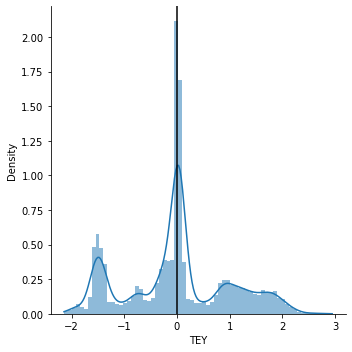

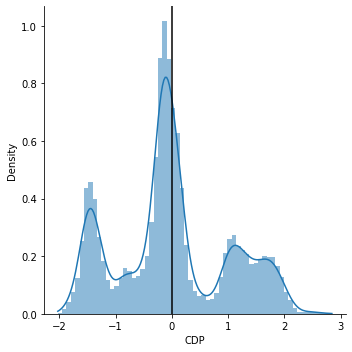

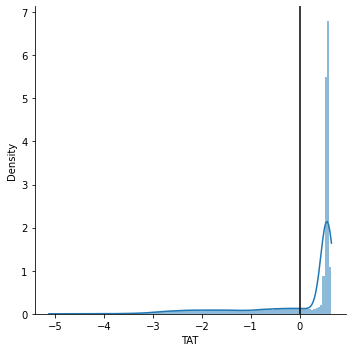

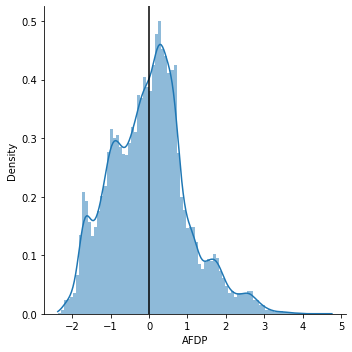

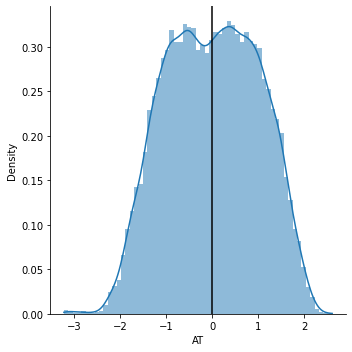

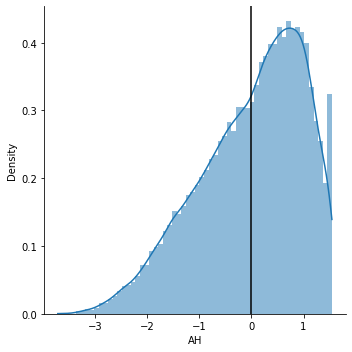

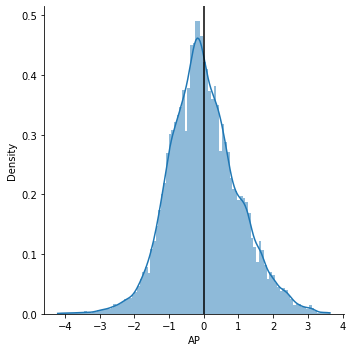

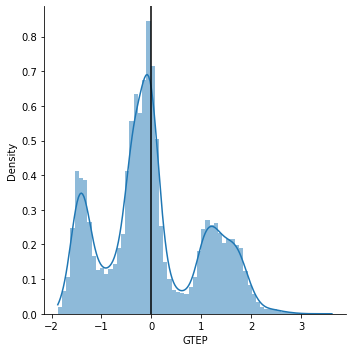

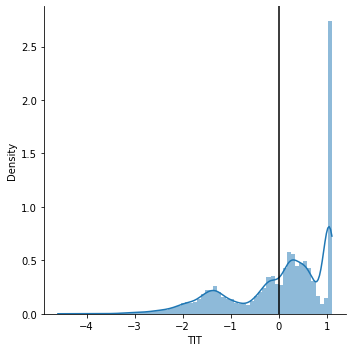

In [26]:

num = frame_standardized.select_dtypes(include=np.number)  # Get numeric columns
n = num.shape[1]  # Number of cols

# fig, axes = plt.subplots(n, 1, figsize=(15,15))  # create subplots

for  col in  num:  # For each column...
    # plt.figure()
    sns.displot(num[col],kde=True, stat="density", linewidth=0)   # Plot histogaerm
    plt.axvline(num[col].mean(), c='k')  # Plot mean

In [22]:
def plot_column(column):
    sns.displot(column,kde=True, stat="density", linewidth=0)   # Plot histogaerm
    plt.axvline(column.mean(), c='k')

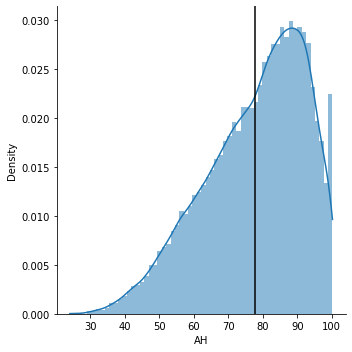

In [24]:
plot_column(frame['AH'])

In [209]:
frame['GTEP'].skew()

0.3290213527194839

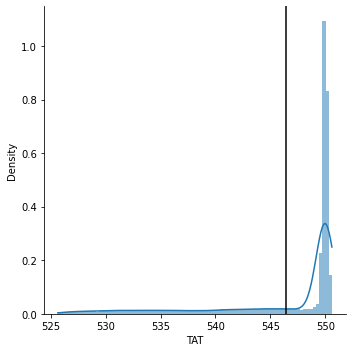

In [23]:
## take only datapoints that lie within 3 std of the mean 
from scipy import stats
std_dev = 3
plot_column(frame['TAT'][(np.abs(stats.zscore(frame['TAT'])) < float(std_dev))])

## yearly trends
plot the yearly trends for each feature and compare
them.

In [13]:
def plot_timeseries(column_name):
    ax = frame.loc[frame['year']==2013][column_name].plot(figsize=(10,10))
    for year in years:
        frame.loc[frame['year']==year].reset_index()[column_name].plot(figsize=(10,10),ax =ax)
    ax.legend(years)
    ax.set_xlabel('Time')
    ax.set_ylabel(column_name)
    return 

### run per column for all timeseries plots

In [229]:
num_feature_columns

['AH', 'AT', 'AFDP', 'TIT', 'TEY', 'AP', 'CDP', 'TAT', 'GTEP']

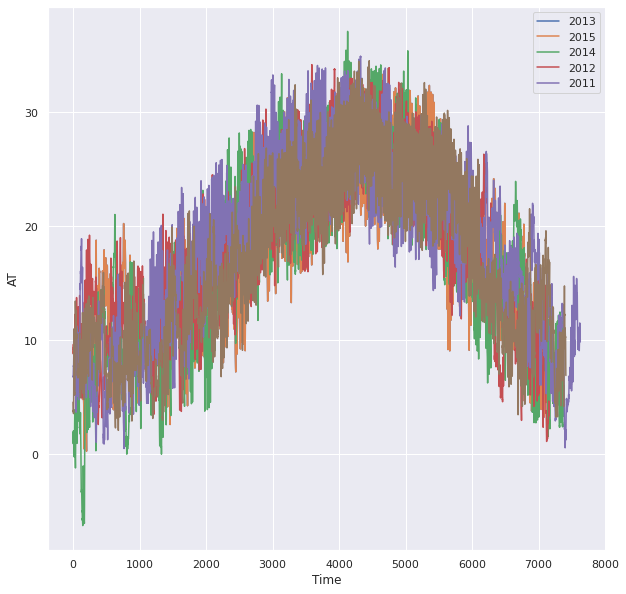

In [ ]:
plot_timeseries('AT')

## Feature Selection 

In [99]:
from sklearn.feature_selection import mutual_info_regression 
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline

In [30]:
train, test = train_test_split(frame, test_size=0.2)

In [67]:
# Un-standardized data full
X_num_full = frame[num_feature_columns].values
y_num_full = frame['CO'].values

In [103]:
# Un-standardized data full
X_num_standardized_full = frame_standardized[num_feature_columns].values
y_num_standardized_full = frame['CO'].values

In [36]:
## Training and Testing numpy arrays
X_train = train[num_feature_columns].values
y_train = train['CO'].values
X_test = test[num_feature_columns].values
y_test = test['CO'].values

In [64]:
# df_mi = pd.DataFrame(mi_reg( frame['CO'],frame[num_feature_columns]), index = num_feature_columns).apply(lambda x: x / x.max(), axis = 1)

def select_features(X_train,X_test,y_train,num_of_features='all'):
    fs = SelectKBest(score_func=mutual_info_regression, k=num_of_features)
    fs.fit(X_train,y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs ,X_test_fs, fs

In [106]:
X_train_fs ,X_test_fs, fs_all =  select_features(X_train,X_test,y_train)

In [107]:
np.argsort(fs_all.scores_)

array([5, 6, 4, 2, 3, 7, 1, 0, 8])

In [144]:
inc_nuinfo_features_num = [num_feature_columns[i] for i in np.argsort(fs_all.scores_)]


In [ ]:
## 1 Function to take a slice of feature columns, slice frame into test and train,standardize (yes or no), and compute rmse with
# the selected features
# 1 -2 subfunction to choose type of data set?
# 2 Function to do gridsearch alpha for lasso and ridge, args: dataset (can slice by specific features)
# 3 Function to do 
# 4 do catagorical variables for frame 
# 5 implement the p value shit 

In [148]:
def compute_rmse_for_features(feature_columns,full_df, standardize =False):
    if standardize is True: 
        df = standardize_dataset(full_df)   
    else:
        df = full_df


    X = df[feature_columns].values
    y = df['CO'].values
    
    regression = LinearRegression()
    scoring_para = 'neg_root_mean_squared_error'
    scores = cross_val_score(regression, X, y,cv =10, scoring=scoring_para)
    return scores.mean()


In [162]:
inc_nuinfo_features_num[-9:]

['AH', 'AP', 'AT', 'TAT', 'AFDP', 'GTEP', 'CDP', 'TEY', 'TIT']

In [169]:
num_features=[]
for i in range(1,len(inc_nuinfo_features_num)+1):
    num_features.append(compute_rmse_for_features(inc_nuinfo_features_num[-i:],frame,standardize=True))
print(np.argmax(num_features))

2


In [120]:
def standardize_dataset(full_df):
    scaler = preprocessing.StandardScaler()
    full_df_stand = full_df.copy(deep=True)
    full_df_stand[num_feature_columns] = scaler.fit_transform(full_df_stand[num_feature_columns])
    return full_df_stand

In [131]:
alphas = np.logspace(-3, 1, 50)
alphas

array([1.00000000e-03, 1.20679264e-03, 1.45634848e-03, 1.75751062e-03,
       2.12095089e-03, 2.55954792e-03, 3.08884360e-03, 3.72759372e-03,
       4.49843267e-03, 5.42867544e-03, 6.55128557e-03, 7.90604321e-03,
       9.54095476e-03, 1.15139540e-02, 1.38949549e-02, 1.67683294e-02,
       2.02358965e-02, 2.44205309e-02, 2.94705170e-02, 3.55648031e-02,
       4.29193426e-02, 5.17947468e-02, 6.25055193e-02, 7.54312006e-02,
       9.10298178e-02, 1.09854114e-01, 1.32571137e-01, 1.59985872e-01,
       1.93069773e-01, 2.32995181e-01, 2.81176870e-01, 3.39322177e-01,
       4.09491506e-01, 4.94171336e-01, 5.96362332e-01, 7.19685673e-01,
       8.68511374e-01, 1.04811313e+00, 1.26485522e+00, 1.52641797e+00,
       1.84206997e+00, 2.22299648e+00, 2.68269580e+00, 3.23745754e+00,
       3.90693994e+00, 4.71486636e+00, 5.68986603e+00, 6.86648845e+00,
       8.28642773e+00, 1.00000000e+01])

In [141]:
def eval_models_regularization(X,y):
    for Model in [Ridge, Lasso]:
        model = Model()
        print('Default params %s: %s' % (Model.__name__,
                        cross_val_score(model, X, y).mean()))

    alphas = np.logspace(-3, 1, 50)

    plt.figure(figsize=(5, 3))

    for Model in [Lasso, Ridge]:
        scores = [cross_val_score(Model(alpha), X, y, cv=10,scoring='neg_root_mean_squared_error').mean()
                for alpha in alphas]
        print("Optimal Alpha {}".format(alphas[np.argmax(scores)]))
        plt.plot(alphas, scores, label=Model.__name__)

    plt.legend(loc='lower left')
    plt.xlabel('alpha')
    plt.ylabel('cross validation score')
    plt.tight_layout()
    plt.show()

Default params Ridge: 0.4264670968226871
Default params Lasso: 0.4757313391748543


/home/anw/ucla_coursework/219/code/ECE219_data_mining_project/env219/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.709e+03, tolerance: 1.594e+01
  model = cd_fast.enet_coordinate_descent(
/home/anw/ucla_coursework/219/code/ECE219_data_mining_project/env219/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.163e+04, tolerance: 1.740e+01
  model = cd_fast.enet_coordinate_descent(
/home/anw/ucla_coursework/219/code/ECE219_data_mining_project/env219/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not conv

Optimal Alpha 0.49417133613238334
Optimal Alpha 10.0


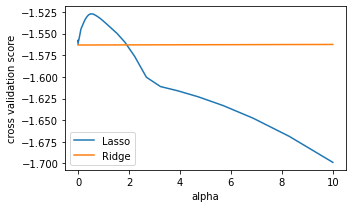

In [142]:
eval_models_regularization(X_num_full,y_num_full)

In [45]:
dict(zip(num_feature_columns,fs.scores_))

{'TEY': 0.49561789002498546,
 'CDP': 0.47229834963763917,
 'TAT': 0.15799763070411998,
 'AFDP': 0.27839019334468684,
 'AT': 0.10793645701283694,
 'AH': 0.022187799028607458,
 'AP': 0.045358869959645,
 'GTEP': 0.44714891679077784,
 'TIT': 0.5358247408137897}

### gridsearch number of features value for standardized and non_standardized frams

In [101]:
cv = RepeatedKFold(n_splits=10, n_repeats=3)
model = LinearRegression()
fs = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])

grid = dict()
grid['sel__k'] = [i for i in range(1,10)]
search = GridSearchCV(pipeline, grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv)
results = search.fit(X_num_full, y_num_full)
# summarize best

print('Best RMSE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

Best RMSE: -1.492
Best Config: {'sel__k': 9}
>-1.598 with: {'sel__k': 1}
>-1.548 with: {'sel__k': 2}
>-1.512 with: {'sel__k': 3}
>-1.512 with: {'sel__k': 4}
>-1.511 with: {'sel__k': 5}
>-1.499 with: {'sel__k': 6}
>-1.495 with: {'sel__k': 7}
>-1.495 with: {'sel__k': 8}
>-1.492 with: {'sel__k': 9}


In [104]:
cv = RepeatedKFold(n_splits=10, n_repeats=3)
model = LinearRegression()
fs = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])

grid = dict()
grid['sel__k'] = [i for i in range(1,10)]
search = GridSearchCV(pipeline, grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv)
results = search.fit(X_num_standardized_full, y_num_full)
# summarize best

print('Best RMSE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

Best RMSE: -1.490
Best Config: {'sel__k': 9}
>-1.596 with: {'sel__k': 1}
>-1.546 with: {'sel__k': 2}
>-1.510 with: {'sel__k': 3}
>-1.510 with: {'sel__k': 4}
>-1.509 with: {'sel__k': 5}
>-1.497 with: {'sel__k': 6}
>-1.493 with: {'sel__k': 7}
>-1.493 with: {'sel__k': 8}
>-1.490 with: {'sel__k': 9}


## Linear Regression

In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV



### Models

In [68]:
regression = LinearRegression()
ridge = Ridge()
lasso = Lasso()

### Q8 Explain how each regularization scheme affects the learned hypotheses
#### LASSO
#### RIDGE

### Q9 Report your choice of the best regularization scheme along with the optimal penalty parameter and briefly explain how it can be computed
GridSearch across Lasso and ridge with alpha values for a given number of features selected for standardized and unstandardized data

In [75]:
scoring_para = 'neg_root_mean_squared_error'
scores = cross_validate(regression, X_num_full, y_num_full,cv =10, scoring=scoring_para)

In [90]:
ridge = Ridge()
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
search = GridSearchCV(ridge, grid, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
results = search.fit(X_num_full, y_num_full)

In [93]:
results.best_params_

{'alpha': 0.99}

{'fit_time': array([0.01013446, 0.02535701, 0.02368903, 0.02424836, 0.0335536 ,
        0.01471663, 0.01166773, 0.0122776 , 0.01482534, 0.0207355 ]),
 'score_time': array([0.00990391, 0.00232911, 0.00251389, 0.00205684, 0.00097275,
        0.00054431, 0.00050998, 0.00187469, 0.00062728, 0.00094795]),
 'test_score': array([-1.59551981, -1.37136031, -1.78438672, -1.5248202 , -1.30764668,
        -2.06751683, -1.4641631 , -1.5269822 , -1.18003719, -1.80899714])}

In [52]:
# fit the model
model = LinearRegression()
model.fit(X_train_fs, y_train)

yhat = model.predict(X_test_fs)
# evaluate predictions
mae = metrics.mean_squared_error(y_test, yhat,squared=False)
print('RMSE: %.3f' % mae)

RMSE: 1.563


In [53]:
regr.fit(frame['AT'].values.reshape(-1,1),frame['CO'])

LinearRegression()

In [ ]:
yhat = model.predict(X_test_fs)
# evaluate predictions
mae = metrics.mean_squared_error(y_test, yhat,squared=False)
print('RMSE: %.3f' % mae)

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [170]:
from sklearn.preprocessing import PolynomialFeatures

In [177]:
maxdegree=7 # The maximum degree we would like to test
training_error=[]
cross_validation_error=[]
for d in range(1,maxdegree):
    x_poly_train=PolynomialFeatures(degree=d).fit_transform(X_num_full)
    # x_poly_test=PolynomialFeatures(degree=d).transform(y_num_full)
    lr=LinearRegression(fit_intercept=False)

    # model=model.fit(x_poly_train,y_num_full)

    # y_train_pred=model.predict(x_poly_train)
    # mse_train=metrics.mean_squared_error(y_train,y_train_pred)
    cve=cross_validate(lr,x_poly_train,y_train,scoring='neg_root_mean_squared_error',cv=5,return_train_score=True)
    # training_error.append(mse_train)
    cross_validation_error.append(np.mean(np.absolute(cve['test_score'])))

fig,ax=plt.subplots(figsize=(6,6))
ax.plot(range(1,maxdegree),cross_validation_error)
ax.set_xlabel('Degree',fontsize=20)
ax.set_ylabel('MSE',fontsize=20)
ax.set_title('MSE VS Degree',fontsize=25)

ValueError: Found input variables with inconsistent numbers of samples: [36733, 29386]